In [1]:
import torch
from dataloader import get_train_and_validation_dataloader
import matplotlib.pyplot as plt
import numpy as np
from data_importer import load_training_images, load_testing_images, trunc, denormalize

In [2]:
def patch_extractor(image, patch_width=64, patch_height=64):
    image = image.copy()
    print(image.shape) 
    num_images, image_height, image_width, channels = image.shape
    patches = image.reshape(-1, image_height // patch_height, patch_height, image_width // patch_width, patch_width, channels)
    patches = patches.swapaxes(2, 3)
    patches = patches.reshape(-1, patch_height, patch_width, channels)
    
    return torch.from_numpy(patches)
 

In [3]:
# Common testing image pairs (used to evaluate all models)
training_dataloader, validation_dataloader = get_train_and_validation_dataloader(root_dataset_dir='../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data', shuffle=False)

number of image paths :  15152
number of image paths :  1472
Train and validation data image len : 15152, 1472


Code for evaluation of model(s)

In [39]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    print(patches.shape, ' shape before reconstructing image from patches')
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))

    # Reconstruct the image by placing each patch in its corresponding position
    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)



In [45]:
def visualize_patches(patches, noisy_images,  ground_truth_images, num_images):
    num_patches_per_image = patches.shape[0] 

    print('num patches per image : ', patches.shape[0])
    for i in range(num_images):
        print('this image has start patches : ', i * num_patches_per_image)
        
        image_patches = patches[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]
        noisy_patches = noisy_images[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]
        clean_patches = ground_truth_images[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]
        
        fig, axes = plt.subplots(1, 4, figsize=(30, 30))
        axes = axes.flatten()
        
        reconstruct_image = (trunc(denormalize((reconstruct_image_from_patches(image_patches, 8)))))
        _noisy_image = trunc(denormalize(reconstruct_image_from_patches(noisy_patches, 8)))
        _clean_image = trunc(denormalize(reconstruct_image_from_patches(clean_patches, 8)))
        
        print('range of reconstructed image : ', np.min(reconstruct_image), np.max(reconstruct_image))
        print('range of clean image : ', np.min(_clean_image), np.max(_clean_image))

        print('reconstruct_image shape : ', reconstruct_image.shape)
        print('noisy image shape : ', noisy_images[i].shape)
        
        axes[0].set_title('input image')
        axes[0].imshow(_noisy_image, cmap='gray', vmin=-160.0, vmax=240.0)
        axes[0].axis('off')
        
        axes[1].set_title('ground truth image')
        axes[1].imshow(_clean_image, cmap='gray', vmin=-160.0, vmax=240.0)
        axes[1].axis('off')
        
        axes[2].set_title('model prediction')
        axes[2].imshow((reconstruct_image), cmap='gray', vmin=-160.0, vmax=240.0)
        axes[2].axis('off')
        
        axes[3].set_title('removed noise')
        axes[3].imshow(trunc(_noisy_image - reconstruct_image), cmap='gray', vmin=-160.0, vmax=240.0)
        axes[3].axis('off')
        
        # print('PSNR of reconsturcted image : ', calculate_psnr(_clean_image, reconstruct_image))
        # print('PSNR of noisy image : ', calculate_psnr(_clean_image, _noisy_image))
        # print('SSIM of noisy image : ', calculate_ssim(_clean_image, _noisy_image))
        # print('SSIM of reconstructed image : ', calculate_ssim(_clean_image, reconstruct_image))
        
        plt.show()


In [59]:
def evaluate_model(model, history, name, psnr_or_accuracy):
    print('Training history of model : ', name)
    
    print('Model prediction test')
   
    prediction_patches = []
    clean_patches = []
    noisy_patches = []

    with torch.no_grad():    
        for i, data in enumerate(validation_dataloader):
            noisy, clean = data
            noisy = torch.squeeze(noisy, 0)
            clean = torch.squeeze(clean, 0)
        
            predictions = model(noisy)

            prediction_patches.append(predictions.detach())
            clean_patches.append(clean.detach())
            noisy_patches.append(noisy.detach())
            print(i)
        
            if i == 3:
                break
        
    prediction_patches = np.concatenate(prediction_patches, axis=0)
    clean_patches = np.concatenate(clean_patches, axis=0)
    noisy_patches = np.concatenate(noisy_patches, axis=0)
    
    print(prediction_patches.shape)
    
    visualize_patches(prediction_patches, noisy_patches, clean_patches,4)
    print('\n\n\n\n\n')
    
    print('\n\n\n\n\n')
    

Test on hformer pytorch

Training history of model :  hformer_64_extended_partial_epoch
Model prediction test
0
1
2
3
(256, 64, 64, 1)
num patches per image :  256
this image has start patches :  0
(256, 64, 64, 1)  shape before reconstructing image from patches
(256, 64, 64, 1)  shape before reconstructing image from patches
(256, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (2048, 512, 1)
noisy image shape :  (64, 64, 1)


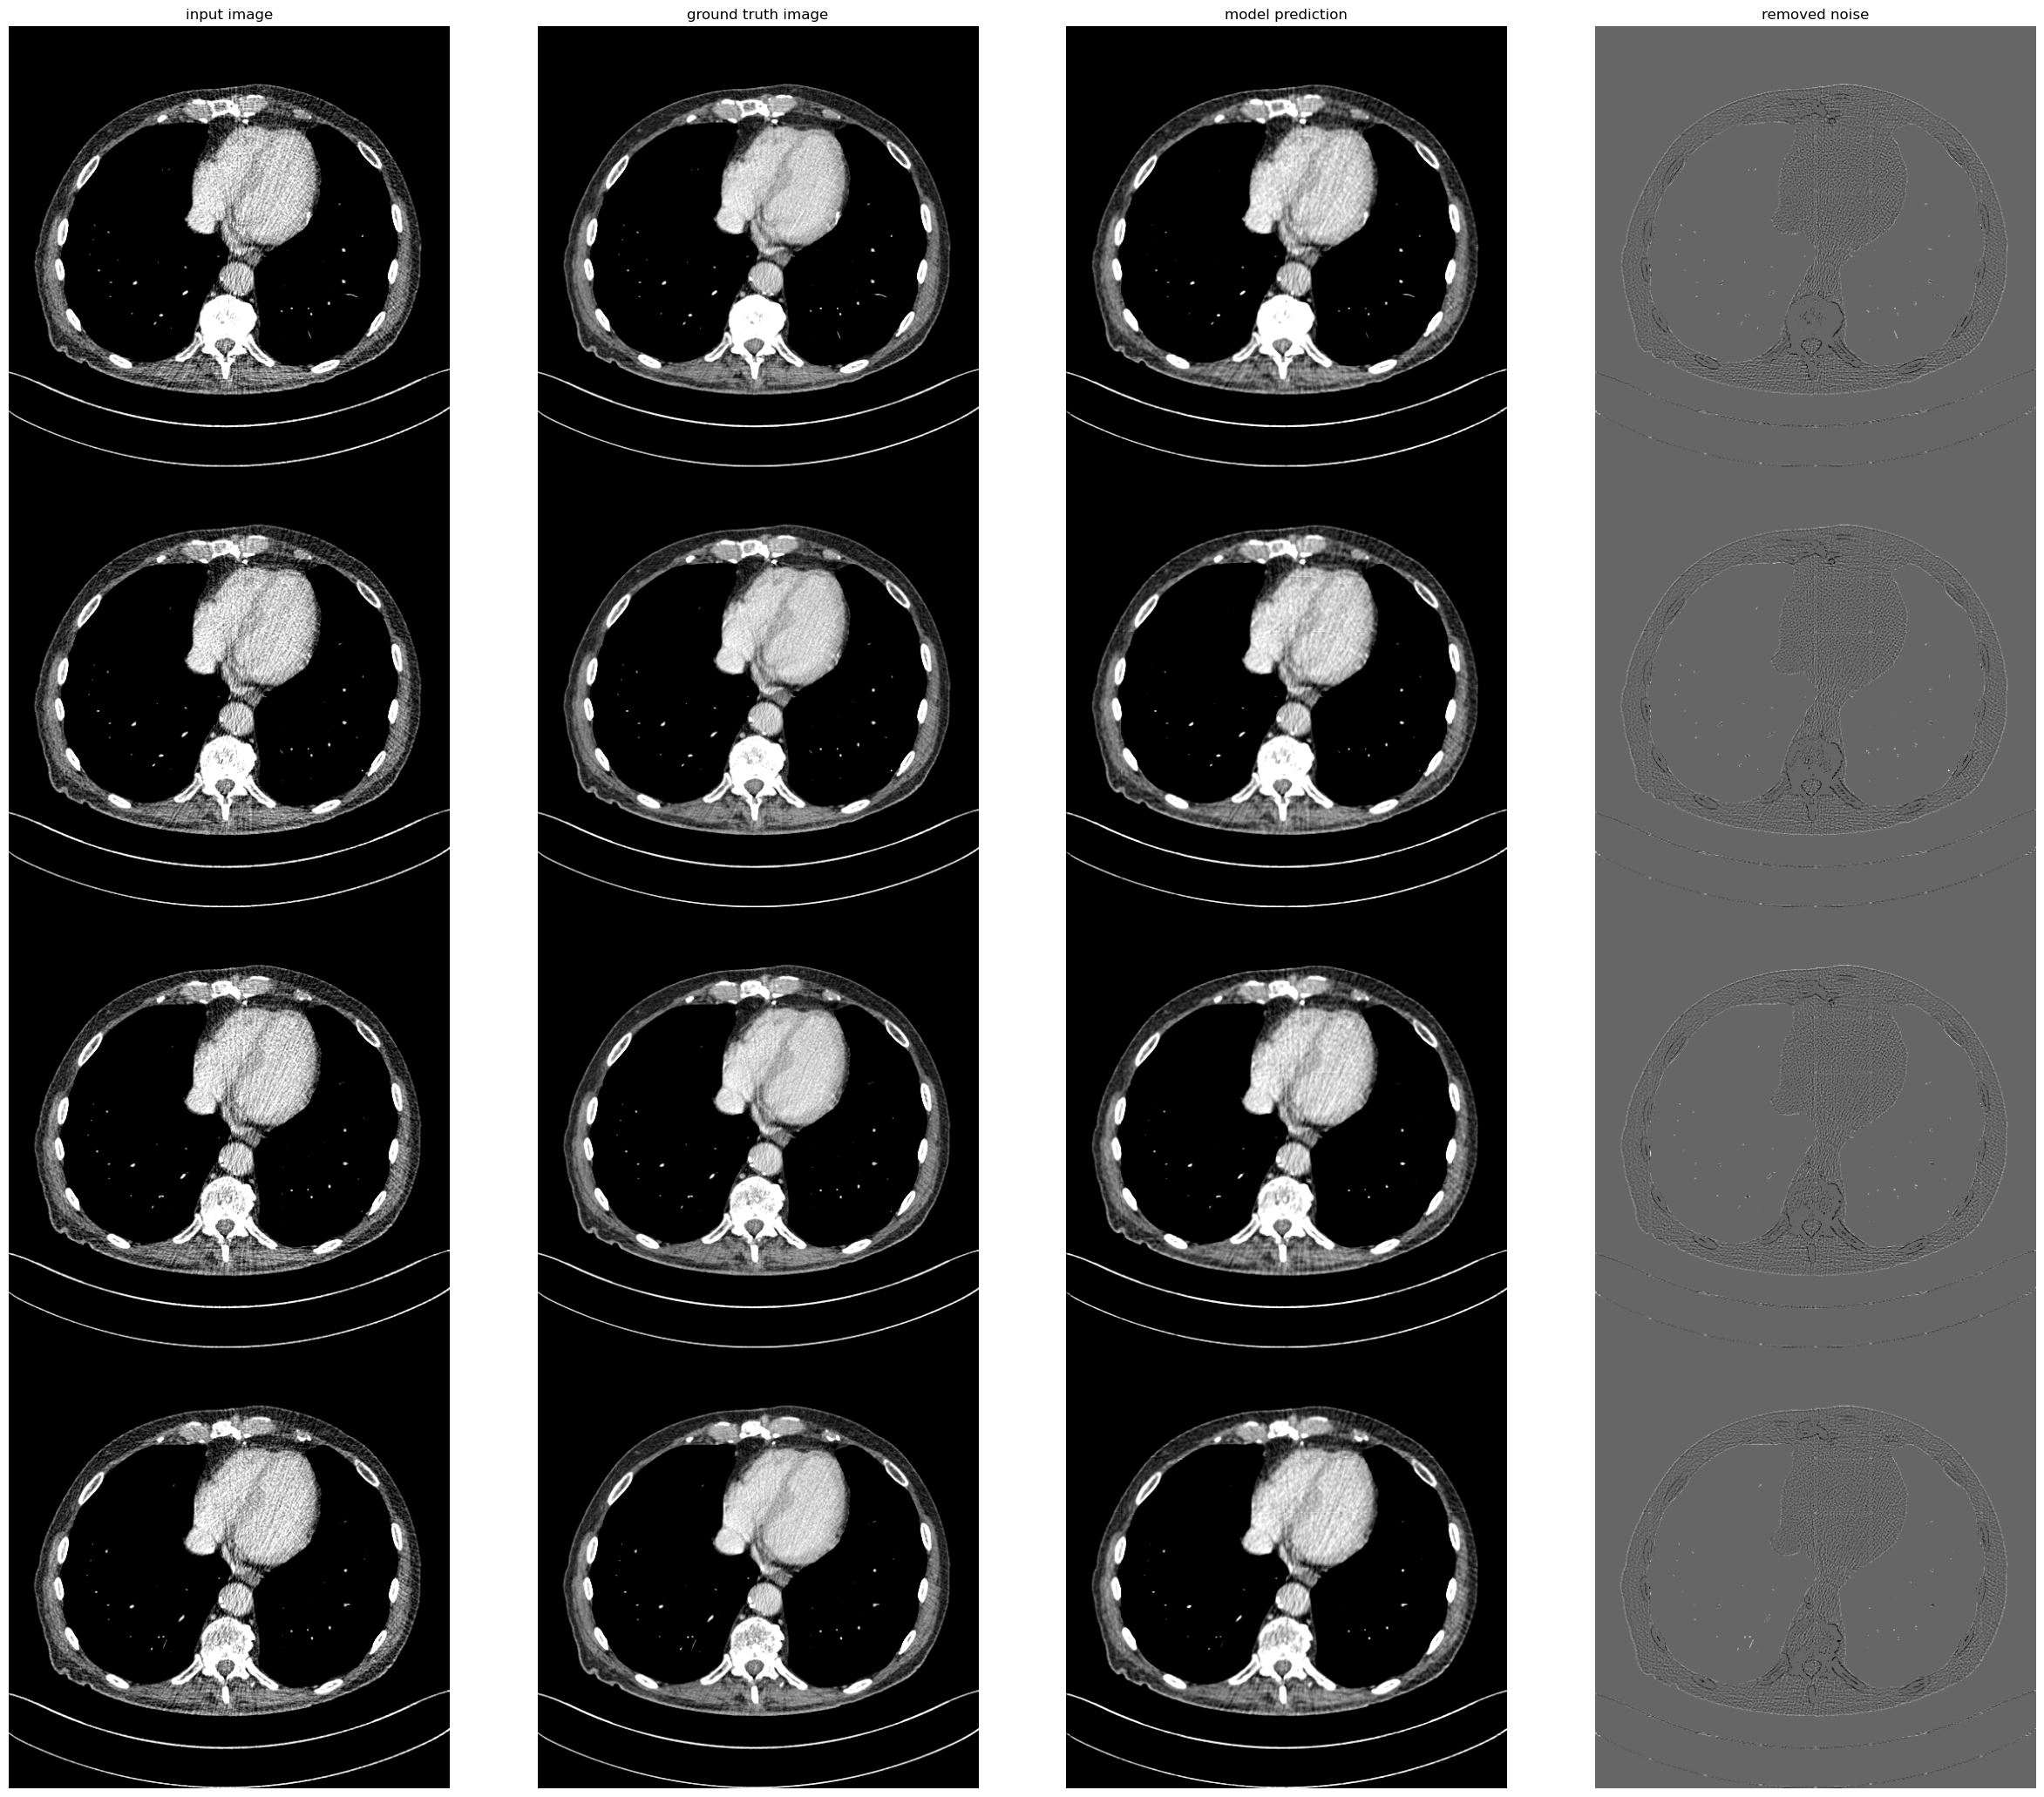

this image has start patches :  256
(0, 64, 64, 1)  shape before reconstructing image from patches
(0, 64, 64, 1)  shape before reconstructing image from patches
(0, 64, 64, 1)  shape before reconstructing image from patches


ValueError: zero-size array to reduction operation minimum which has no identity

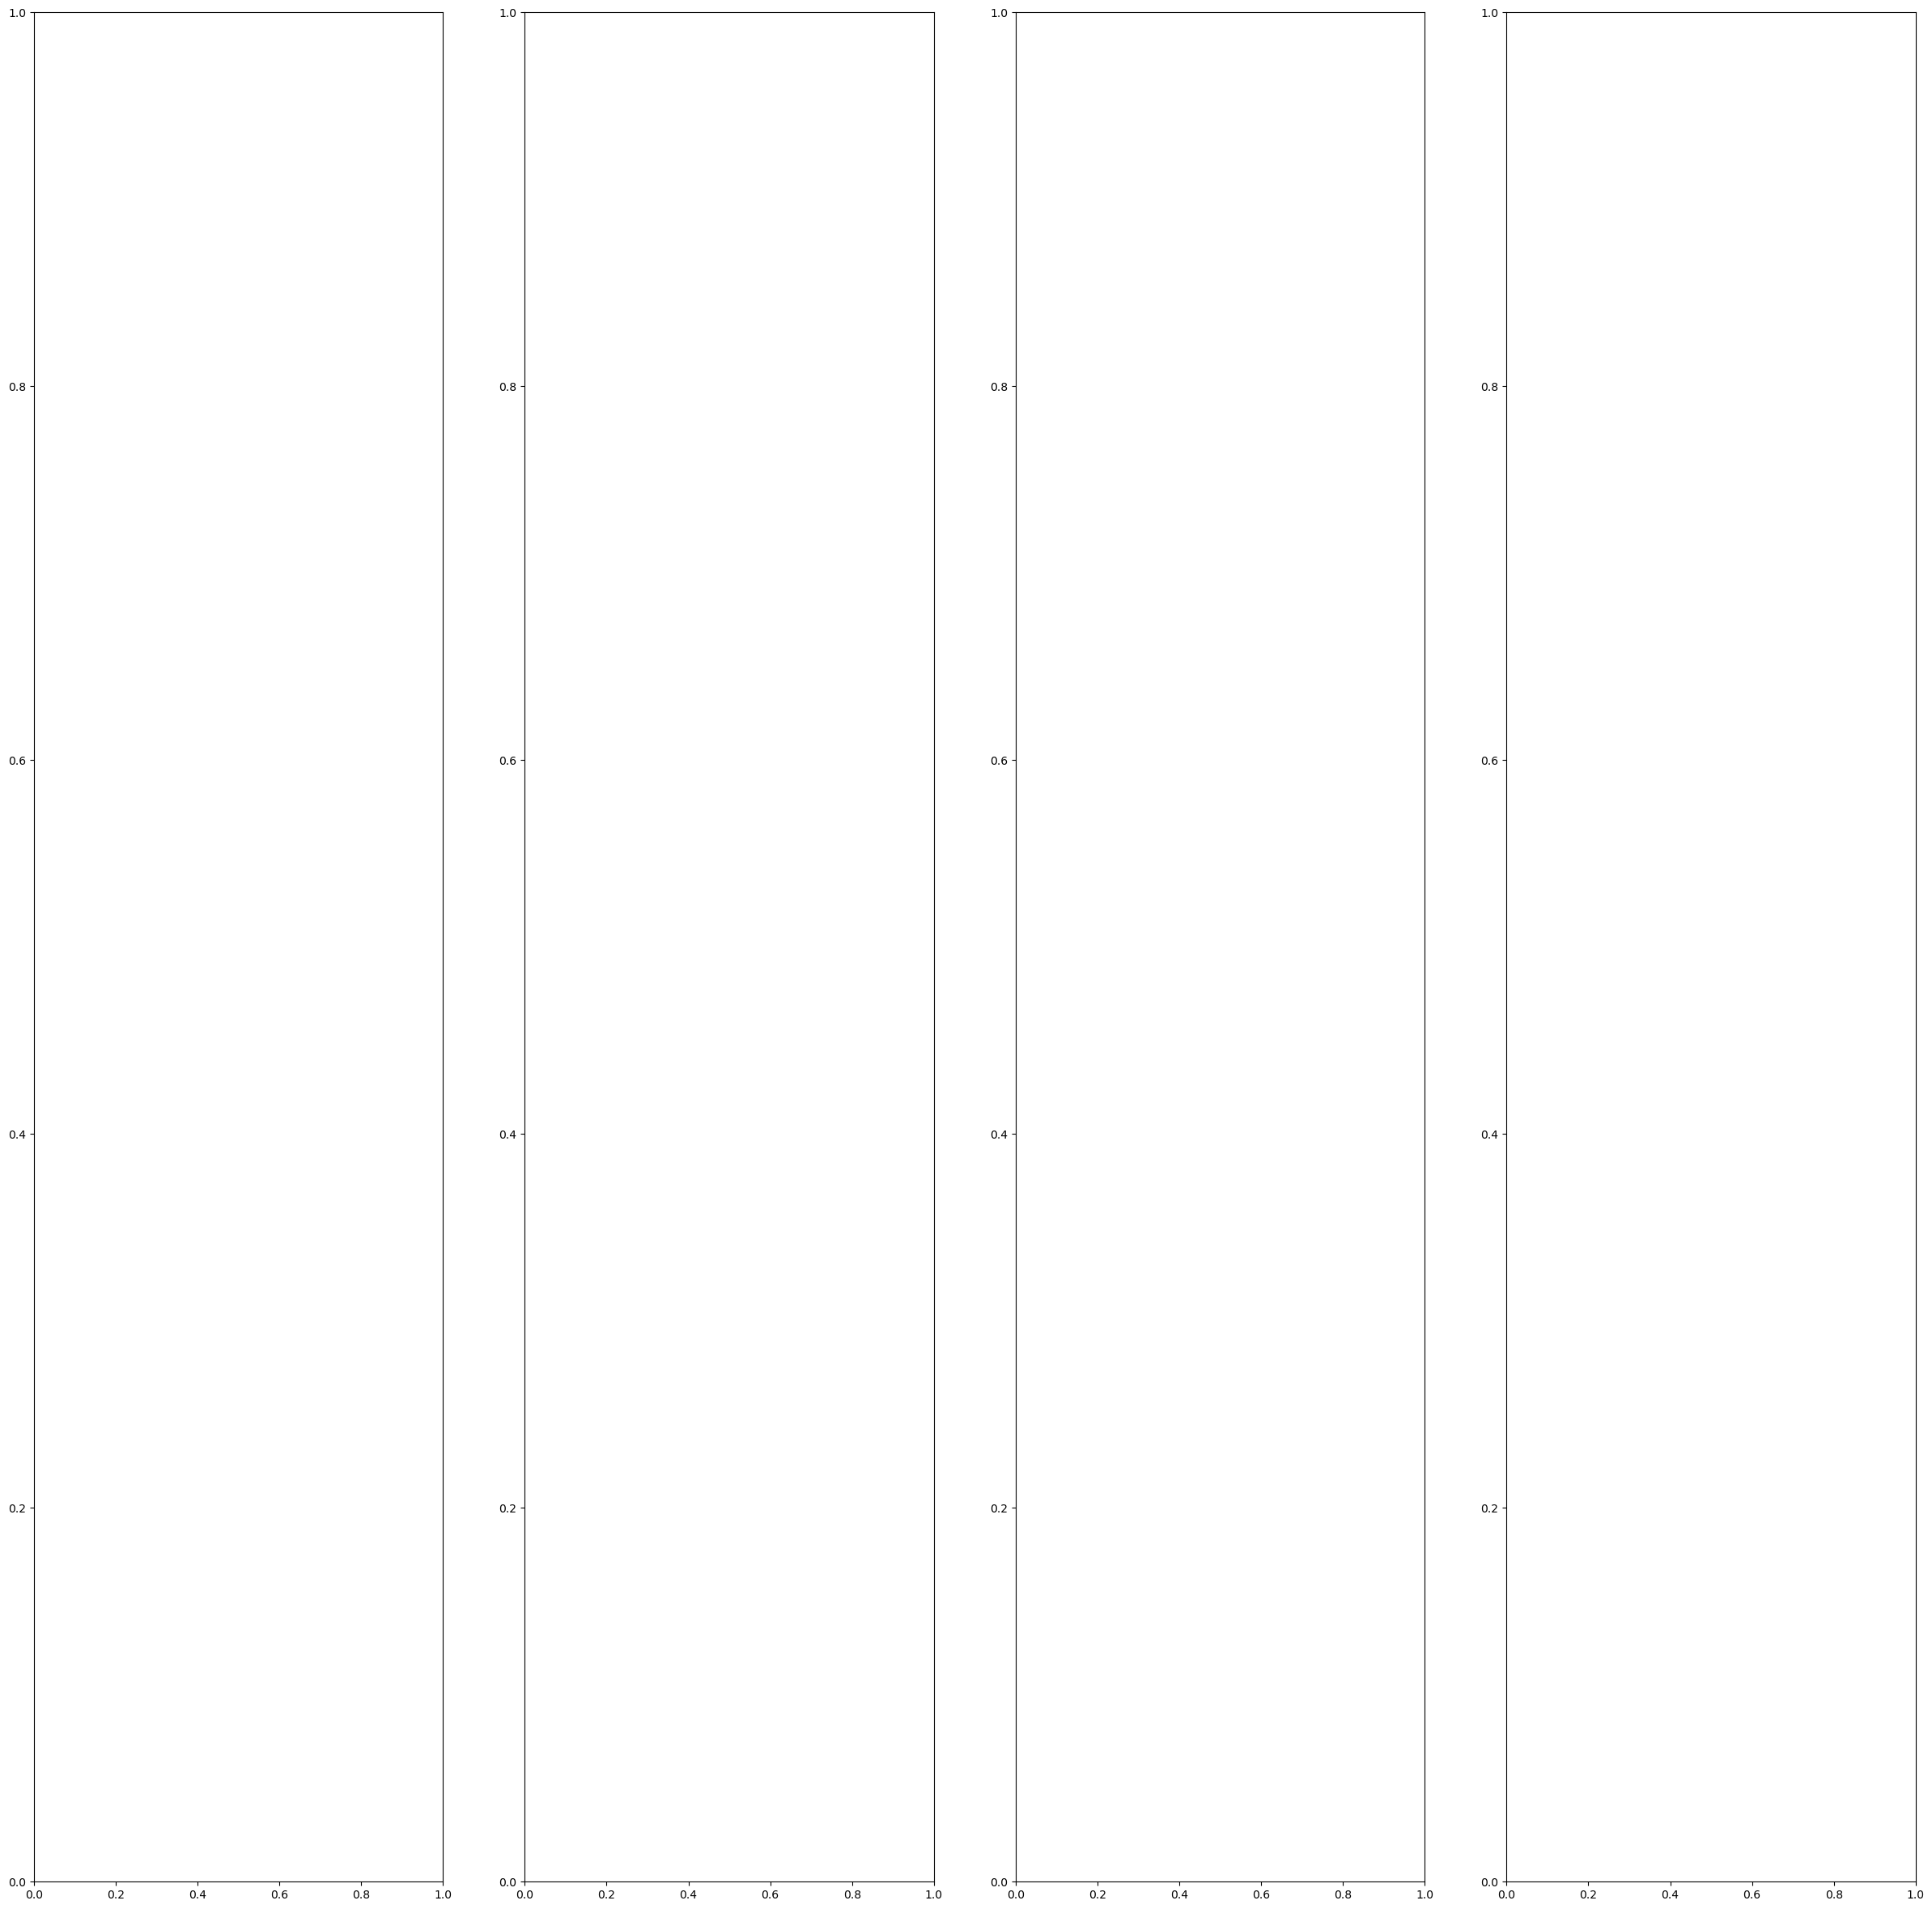

In [60]:
from hformer_model import HformerModel

model = HformerModel(num_channels=64)
model.load_state_dict(torch.load('weights/model_15.pth'))
model.eval()

evaluate_model(model, None, 'hformer_64_extended_partial_epoch', 'psnr')